In [1]:
%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import gaussian_filter

from vizlib import *

In [2]:
filename = "/Volumes/DATA/data_06_11_2023-5/amatter_06_11_2023-5_worms_only.xyzv"
filename = "/Volumes/DATA/data_03_12_2023/amatter_03_12_2023-1_worms_only.xyzv"
N,nframes,pos_data,vel_data = load_data(filename)

12000  particles per frame
Loading  1001  frames of data...


100%|██████████| 1001/1001 [00:19<00:00, 51.70it/s]


In [3]:
vector_field = get_particle_vecs_frame(N,-1,pos_data)

num_worms: 750


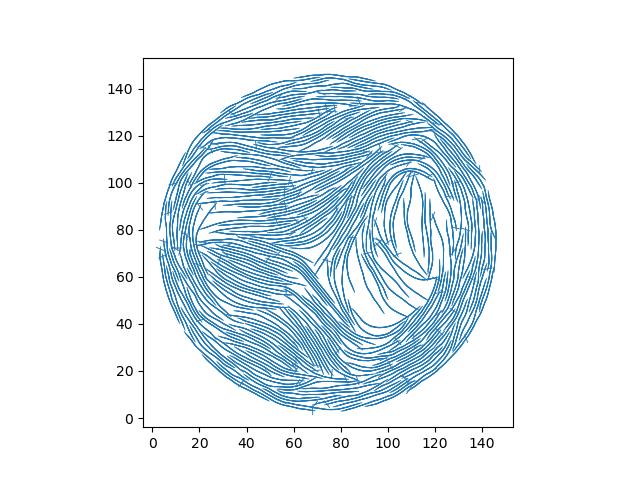

In [4]:
"""plotting the vectors of each of the individual particles"""
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(vector_field[:,0], #x
                   vector_field[:,1], #y
                   vector_field[:,3], #u
                   vector_field[:,4], #v
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

In [5]:
num_interpolation_points = 100
interpolation_type = "cubic"#"linear"
vector_grid = interp_particle_vecs(vector_field,num_interpolation_points,interpolation_type)

X: 3.25537 145.9 142.64463
Y: 3.25583 146.03 142.77417


(10000, 4)


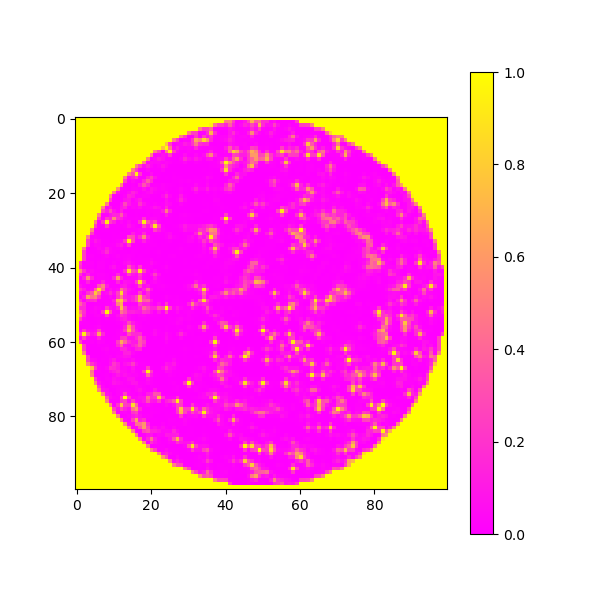

In [6]:
E = get_energy_simple(vector_grid,num_interpolation_points)
fig,ax = plt.subplots(1,1,figsize=(6,6))
pcm = ax.imshow(E,cmap="spring")
fig.colorbar(pcm, ax=ax)
plt.show()

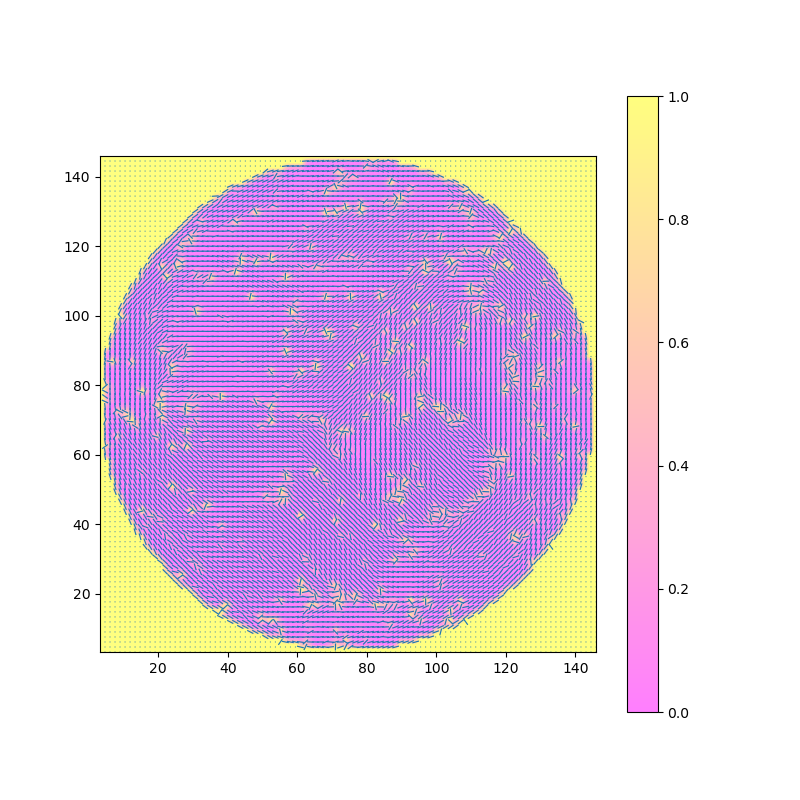

In [7]:
"""plotting the vectors of each grid"""
fig,ax = plt.subplots(1,1,figsize=(8,8))
quiver = ax.quiver(vector_grid[:,0], #x
                   vector_grid[:,1], #y
                   vector_grid[:,2], #u
                   vector_grid[:,3], #v
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
pcm = ax.imshow(E,cmap="spring",interpolation="bilinear",alpha=0.5,origin="lower",extent=(vector_grid[:,0][0],vector_grid[:,0][-1],vector_grid[:,1][0],vector_grid[:,1][-1]))
fig.colorbar(pcm, ax=ax)
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

(100, 100)


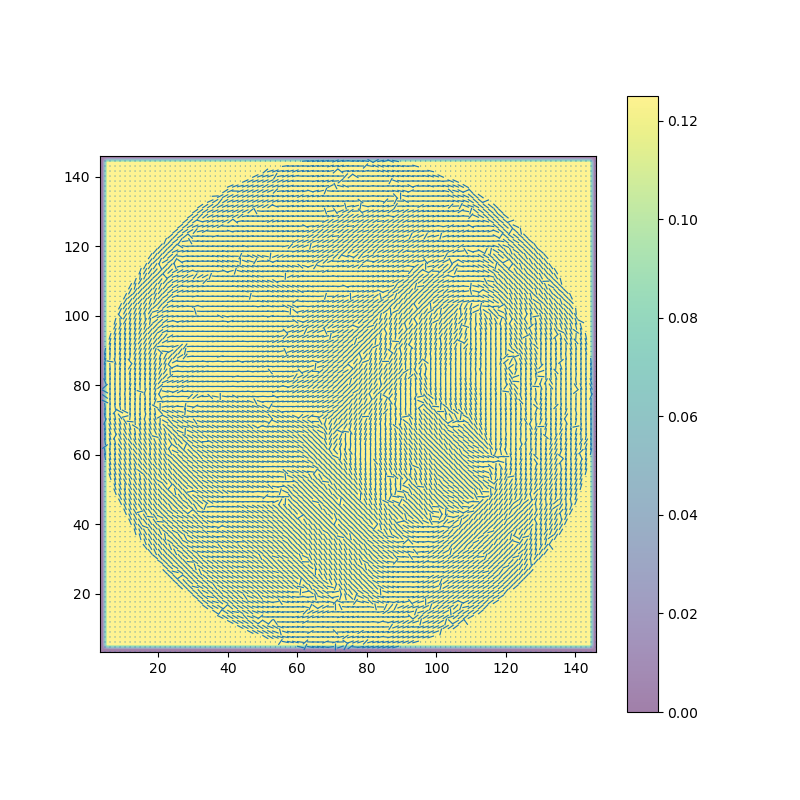

In [12]:
def calculate_order_parameter(field):
    # Assuming field is a 2D array of vectors (size x size x 2)
    S = np.zeros((field.shape[0],field.shape[1]))
    for i in np.arange(1,field.shape[0]-1):
        for j in np.arange(1,field.shape[1]-1):
            nx = field[i,j,0]
            ny = field[i,j,1]
            orig_theta = np.arctan2(ny,nx)
            theta = 3*(np.cos((np.arctan2(field[i+1,j,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i+1,j+1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i+1,j-1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i,j+1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i,j-1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i-1,j+1,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i-1,j,1],field[i+1,j,0])-orig_theta)+
                              (np.arctan2(field[i-1,j-1,1],field[i+1,j,0])-orig_theta))**2)-1

            S[i,j] = 0.5*theta/8

    return S
temp_field = np.zeros((num_interpolation_points,num_interpolation_points,2))
temp_field[:,:,0] = vector_grid[:,2].reshape(num_interpolation_points,num_interpolation_points)
temp_field[:,:,0] = vector_grid[:,3].reshape(num_interpolation_points,num_interpolation_points)
order_parameter_original = calculate_order_parameter(temp_field)

# Plot the original and interpolated defect fields with the order parameter
fig,ax = plt.subplots(1,1,figsize=(8,8))
quiver = ax.quiver(vector_grid[:,0], #x
                   vector_grid[:,1], #y
                   vector_grid[:,2], #u
                   vector_grid[:,3], #v
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
print(order_parameter_original.shape)
pcm = ax.imshow(order_parameter_original,cmap="viridis",interpolation="bilinear",alpha=0.5,origin="lower",extent=(vector_grid[:,0][0],vector_grid[:,0][-1],vector_grid[:,1][0],vector_grid[:,1][-1]))
fig.colorbar(pcm, ax=ax)
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

In [8]:
from matplotlib.animation import FuncAnimation

# Assuming you have a list of vector fields called 'vector_fields'
vector_fields = []
for iframe in tqdm.tqdm(range(nframes)):
    vector_field_frame = get_particle_vecs_frame(N,iframe,pos_data,disp=False)
    vector_grid_frame = interp_particle_vecs(vector_field_frame,100,"cubic",disp=False)
    vector_fields.append(vector_grid_frame)
    
fig, ax = plt.subplots(1, 1)

def update(frame):
    ax.clear()
    vector_grid = vector_fields[frame]
    quiver = ax.quiver(vector_grid[:, 0], vector_grid[:, 1], vector_grid[:, 2], vector_grid[:, 3],
                       pivot='mid',
                       headlength=0,
                       headwidth=0,
                       headaxislength=0,
                       color="tab:blue",
                       scale_units='xy',
                       scale=0.25
                       )
    ax.set_box_aspect(1)
    ax.set_adjustable("datalim")
    ax.set_title(f'Timestep {frame}')

def update_with_energy(frame):
    ax.clear()
    vector_grid = vector_fields[frame]
    quiver = ax.quiver(vector_grid[:, 0], vector_grid[:, 1], vector_grid[:, 2], vector_grid[:, 3],
                       pivot='mid',
                       headlength=0,
                       headwidth=0,
                       headaxislength=0,
                       color="tab:blue",
                       scale_units='xy',
                       scale=0.25
                       )
    
    pcm = ax.imshow(get_energy_simple(vector_grid,num_interpolation_points,disp=False),
              cmap="spring",
              interpolation="bilinear",
              alpha=0.5,origin="lower",
              extent=(vector_grid[:,0][0],vector_grid[:,0][-1],vector_grid[:,1][0],vector_grid[:,1][-1])
              )
    ax.axis("scaled")
    #fig.colorbar(pcm, ax=ax)
    ax.set_box_aspect(1)
    ax.set_adjustable("datalim")
    ax.set_title(f'Timestep {frame}')

# Create the animation
animation = FuncAnimation(fig, update_with_energy, frames=nframes, interval=200, repeat=False)
#saving the animation
#animation.save('vector_field_animation.mp4', writer='ffmpeg', fps=10)
#plt.show()


  2%|▏         | 23/1001 [00:11<07:48,  2.09it/s]


KeyboardInterrupt: 

(12000, 3)
(12000, 3)


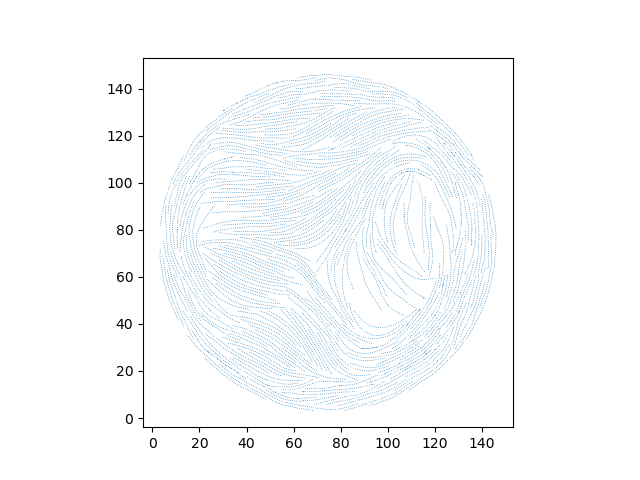

In [9]:
print(pos_data[-1].shape)
print(pos_data[-1].shape)
vector_field = np.zeros((N,6))
vector_field[:,0:3] = pos_data[-1]
vector_field[:,3:6] = vel_data[-1]
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(vector_field[:,0], #x
                   vector_field[:,1], #y
                   vector_field[:,3], #u
                   vector_field[:,4], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

(12000, 3)
(12000, 3)


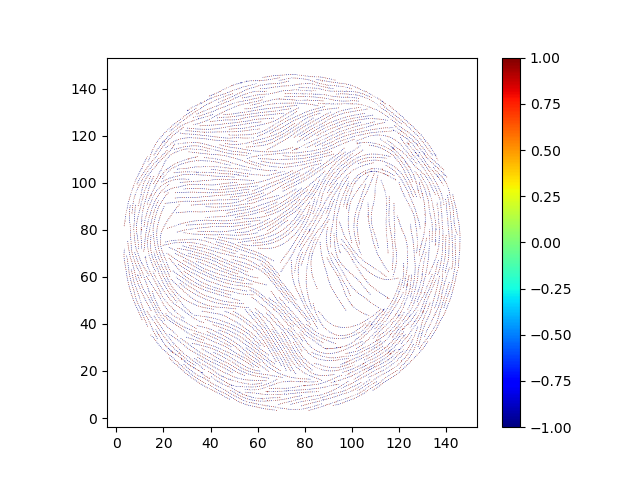

In [15]:
print(pos_data[-1].shape)
print(pos_data[-1].shape)
vector_field = np.zeros((N,6))
vector_field[:,0:3] = pos_data[-1]
vector_field[:,3:6] = vel_data[-1]
# use magnitude of velocity as a coloring
vel_mag = np.zeros(N)
vel_mag = np.sqrt(vector_field[:,3]**2 + vector_field[:,4]**2 + vector_field[:,5]**2)
vorticity = np.gradient(vector_field[:,4], axis=0) - np.gradient(vector_field[:,2], axis=0)
rot_dir = np.sign(vorticity)
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(vector_field[:,0], #x
                   vector_field[:,1], #y
                   vector_field[:,3], #u
                   vector_field[:,4], #v
                   rot_dir,
                   pivot='mid',
                   #color="tab:blue",
                   cmap = 'jet',
                   scale_units='xy',
                   scale=0.25
)
ax.set_adjustable("datalim")
cbar = plt.colorbar(quiver, ax=ax)
#cbar.set_label('Vel. Magnitude')
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

100%|██████████| 1001/1001 [00:00<00:00, 4728.30it/s]


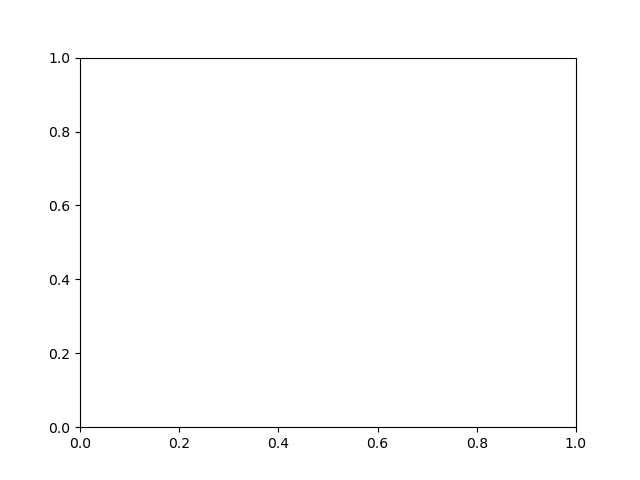

/var/folders/19/6ybwbhjn1j73pvt1f96bh1j40000gn/T/ipykernel_7868/2061906216.py:22: RuntimeWarning: invalid value encountered in divide
  vector_grid[:,3] = vector_grid[:,3]/vel_mag
/var/folders/19/6ybwbhjn1j73pvt1f96bh1j40000gn/T/ipykernel_7868/2061906216.py:23: RuntimeWarning: invalid value encountered in divide
  vector_grid[:,4] = vector_grid[:,4]/vel_mag
/var/folders/19/6ybwbhjn1j73pvt1f96bh1j40000gn/T/ipykernel_7868/2061906216.py:24: RuntimeWarning: invalid value encountered in divide
  vector_grid[:,5] = vector_grid[:,5]/vel_mag


In [ ]:
""" animating the previous plot"""
from matplotlib.animation import FuncAnimation

# Assuming you have a list of vector fields called 'vector_fields'
vector_fields = []
for iframe in tqdm.tqdm(range(nframes)):
    vector_field_frame = np.zeros((N,6))
    vector_field_frame[:,0:3] = pos_data[iframe]
    vector_field_frame[:,3:6] = vel_data[iframe]
    #vector_field_frame = get_particle_vecs_frame(N,iframe,pos_data,disp=False)
    #vector_grid_frame = interp_particle_vecs(vector_field_frame,100,"cubic",disp=False)
    vector_fields.append(vector_field_frame)
    
fig, ax = plt.subplots(1, 1)

def update(frame):
    ax.clear()
    vector_grid = vector_fields[frame]
    vel_mag = np.zeros(N)
    vel_mag = np.sqrt(vector_grid[:,3]**2 + vector_grid[:,4]**2 + vector_grid[:,5]**2)
    # normalizing the vector size
    vector_grid[:,3] = vector_grid[:,3]/vel_mag
    vector_grid[:,4] = vector_grid[:,4]/vel_mag
    vector_grid[:,5] = vector_grid[:,5]/vel_mag
    quiver = ax.quiver(vector_grid[:, 0], vector_grid[:, 1], vector_grid[:, 3], vector_grid[:, 4],
                       vel_mag,
                       cmap = 'jet',
                       pivot='mid',
                       color="tab:blue",
                       scale_units='xy',
                       scale=0.25
                       )
    ax.set_box_aspect(1)
    ax.set_adjustable("datalim")
    ax.set_title(f'Timestep {frame}')
    
# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=100, repeat=False)
#saving the animation
#animation.save('vector_field_animation.mp4', writer='ffmpeg', fps=10)
#plt.show()
